In [4]:
import numpy as np 
import random 
from copy import deepcopy
from math import sqrt, log, exp 
from numba import jit
from collections import Counter
import matplotlib.pyplot as plt 

class Bandit:
    class Arm:
        def __init__(self, prob=0):
            self.p = prob

        def get(self):
            return 1 if np.random.uniform(0, 1) < self.p else 0
            
    def __init__(self, probs):
        self.arms = [Bandit.Arm(prob) for prob in probs]
    
    def get(self, arm_no):
        return self.arms[arm_no].get()


def eps_greedy(N, eps, bandit):
    theta = [0, 0, 0]
    count = [0, 0, 0]
    choices = np.array([0]*N)
    rewards = np.array([0]*N)
    total_reward = 0
    for i in range(N):
        It = 0
        if random.uniform(0, 1) < eps:
            It = random.choice([0, 1, 2])
        else:
            It = theta.index(max(theta))
        count[It] += 1
        choices[i] = It
        r_It = bandit.get(It)
        rewards[i] = r_It
        total_reward += r_It
        theta[It] += (1/count[It])*(r_It - theta[It])
    return theta, total_reward, choices, rewards

def UCB(N, c, bandit):
    count = [0, 0, 0]
    theta = [0, 0, 0]
    choices = np.array([0]*N)
    rewards = np.array([0]*N)
    total_reward = 0
    for t in range(3):
        count[t] = 1
        theta[t] = bandit.get(t)
        choices[t] = t
    for t in range(3, N):
        temp = [ (theta[j] + c*sqrt(2*log(t+1)/count[j]) ) for j in range(3) ]
        It = temp.index(max(temp))
        count[It] += 1
        choices[t] = It
        r_It = bandit.get(It)
        rewards[t] = r_It
        total_reward += r_It
        theta[It] += (1/count[It])*(r_It - theta[It])
    return theta, total_reward, choices, rewards

def TS(N, params, bandit):
    ret_params = deepcopy(params)
    total_reward = 0
    choices = np.array([0]*N)
    rewards = np.array([0]*N)
    for t in range(N):
        theta = [0, 0, 0]
        for j in range(3):
            theta[j] = np.random.beta(ret_params[j][0], ret_params[j][1])
        It = theta.index(max(theta))
        choices[t] = It
        r_It = bandit.get(It)
        rewards[t] = r_It
        total_reward += r_It
        ret_params[It][0] += r_It
        ret_params[It][1] += 1-r_It
    theta = [p[0]/(p[0] + p[1]) for p in ret_params]
    return theta, total_reward, choices, rewards

@jit
def choice(weights):
    It = -1
    rand = np.random.uniform(0, 1)
    if rand < weights[0]: 
        It = 0
    elif rand >= weights[0] and rand < weights[0] + weights[1]: 
        It = 1
    else: 
        It = 2
    return It

@jit
def softmax(l, beta):
    mx = np.max(l)
    tmp = np.exp(beta*(l-mx))
    return tmp/sum(tmp)

@jit(nopython=False)
def gradient(N, params, bandit):
    baseline, beta = params[0], params[1]
    H = np.zeros((3), dtype=np.float)
    count = np.zeros((3), dtype=np.int)
    choices = np.array([0]*N)
    rewards = np.array([0]*N)
    avg_reward = 0
    for t in range(N):
        policy = softmax(H, beta)
        It = choice(policy)
        choices[t] = It
        r_It = bandit.get(It)
        rewards[t] = r_It 
        count[It] += 1
        avg_reward = (t/(t+1))*avg_reward + (1/(t+1))*r_It 
        base = avg_reward if baseline == -1 else baseline
        for i in range(3):
            if i == It: 
                H[i] += 0.1*(r_It - base)*(1 - policy[i])
            else: 
                H[i] -= 0.1*(r_It - base)*policy[i]
    theta = [c/N for c in count]
    return theta, avg_reward*N, choices, rewards
    

def simulate(algorithm, N, repeat, params, figname, param_name):
    b = Bandit([0.9, 0.8, 0.7])
    colors = ['r', 'g', 'b', 'violet']
    lines, opts = [], []
    fig0 = plt.figure()
    fig1 = plt.figure()
    ax = [fig0.add_axes([0.1,0.1,0.8,0.8]), fig1.add_axes([0.1,0.1,0.8,0.8])]
    for rep in range(len(params)):
        th_total = [0, 0, 0]
        res  = np.zeros(shape=(repeat, N), dtype=np.int)
        res2 = np.zeros(shape=(repeat, N), dtype=np.int)
        reward_total = 0
        for ii in range(repeat):
            th, re, ch, rwd = algorithm(N, params[rep], b)
            for i in range(3):
                th_total[i] += th[i]
            for j in range(N):
                res[ii][j] = ch[j]
                res2[ii][j] = rwd[j]
            reward_total += re
            
        t = np.zeros(N)
        regret = np.zeros(N)
        opt_choices = np.zeros(N)
        overall_regret = 0
        for i in range(N):
            ith_choices = res[:, i]
            ith_rewards = res2[:, i]
            d = {0:[0,0], 1:[0,0], 2:[0,0]}
            for x in range(repeat):
                xch = ith_choices[x]
                d[xch][0] += 1 # number of choices
                d[xch][1] += ith_rewards[x] # rewards of chosen this
            t[i] = i
            for kk in range(3):      
                if d[kk][0] != 0: 
                    overall_regret += (d[kk][0]*(0.9-(d[kk][1]/d[kk][0])))/repeat          
            opt_choices[i] = d[0][0]/repeat
            regret[i] = overall_regret
        fig, = ax[0].plot(t, regret, c=colors[rep])
        opt, = ax[1].plot(t, opt_choices, c=colors[rep])
        lines.append(fig)
        opts.append(opt)
        print("Overall regret = {}".format(overall_regret))
        print("Average aggragate reward: {}".format(reward_total/repeat))
        print("Average theta: th_1 = {}, th_2 = {}, th_3 = {}".format(th_total[0]/repeat, th_total[1]/repeat, th_total[2]/repeat))
    ax[0].set_title(figname + " regret(t)")
    ax[1].set_title(figname + " optimal choices (%)")
    ax[0].legend(lines, [param_name + "={}".format(params[rep][1])  for rep in range(len(params))])
    ax[1].legend(opts , [param_name + "={}".format(params[rep][1])  for rep in range(len(params))])
    ax[0].set_ylabel("regret(t)")
    ax[0].set_xlabel("time step(t)")
    ax[1].set_ylabel("optimal choices (%)")
    ax[1].set_xlabel("time step(t)")
    plt.show()
    
    

Overall regret = 53.50800000000084
Average aggragate reward: 4446.492
Average theta: th_1 = 0.9001065885129174, th_2 = 0.7989615970147347, th_3 = 0.7011493667259728
Overall regret = 250.97800000000072
Average aggragate reward: 4249.022
Average theta: th_1 = 0.9002387395728314, th_2 = 0.8004224341904301, th_3 = 0.6998580888647297
Overall regret = 449.91600000000335
Average aggragate reward: 4050.084
Average theta: th_1 = 0.8999652366528664, th_2 = 0.8000937707272548, th_3 = 0.7003939263441958


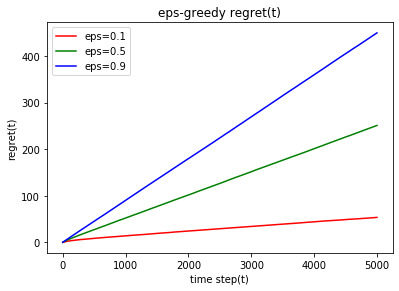

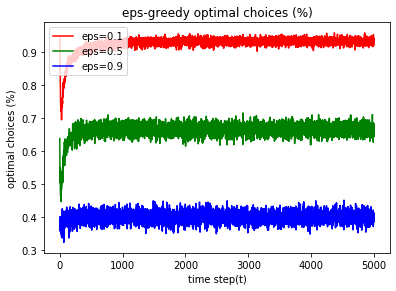

In [23]:
simulate(eps_greedy, 5000, 1000, [0.1, 0.5, 0.9], "eps-greedy", "eps")

Overall regret = 114.09000000000033
Average aggragate reward: 4385.91
Average theta: th_1 = 0.8999849493608738, th_2 = 0.7967047905003363, th_3 = 0.6930130115479661
Overall regret = 374.56799999999953
Average aggragate reward: 4125.432
Average theta: th_1 = 0.899977187257328, th_2 = 0.8000169077622954, th_3 = 0.7000629364311939
Overall regret = 437.8540000000021
Average aggragate reward: 4062.146
Average theta: th_1 = 0.8996888351719253, th_2 = 0.7996786693561247, th_3 = 0.6999247840611406


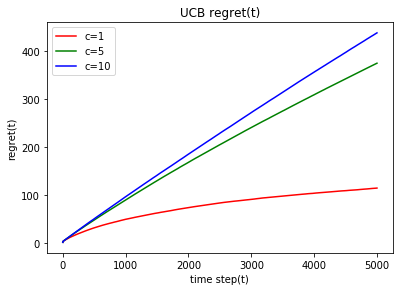

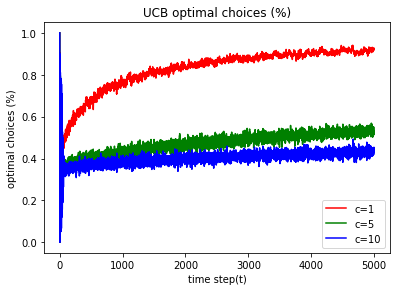

In [29]:
simulate(UCB, 5000, 1000, [1,5,10], "UCB", "c")

Overall regret = 15.985000000000637
Average aggragate reward: 4484.015
Average theta: th_1 = 0.8996174705201779, th_2 = 0.7455336308337458, th_3 = 0.6160367979980115
Overall regret = 723.7999999999985
Average aggragate reward: 3776.2
Average theta: th_1 = 0.683514023947364, th_2 = 0.4001996007984122, th_3 = 0.6702805408580191


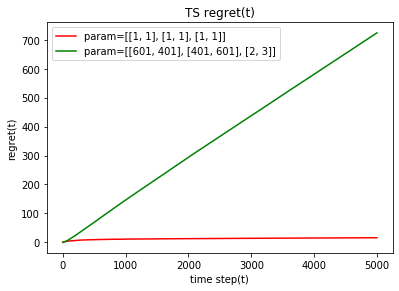

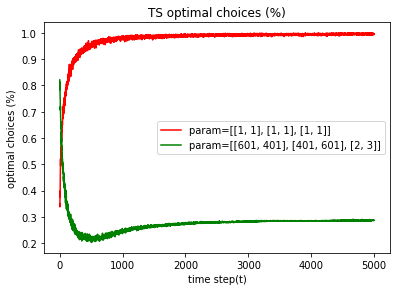

In [30]:
simulate(TS, 5000, 1000, [[[1,1],[1,1],[1,1]], [[601,401],[401,601],[2,3]]] , "TS", "param")

Overall regret = 74.7619999999999
Average aggragate reward: 4425.238
Average theta: th_1 = 0.8983191999999993, th_2 = 0.050907399999999985, th_3 = 0.05077340000000005
Overall regret = 68.92000000000024
Average aggragate reward: 4431.08
Average theta: th_1 = 0.9065943999999989, th_2 = 0.046766999999999934, th_3 = 0.04663859999999999
Overall regret = 299.5299999999987
Average aggragate reward: 4200.47
Average theta: th_1 = 0.6013545999999994, th_2 = 0.19934380000000002, th_3 = 0.19930160000000005
Overall regret = 390.4190000000006
Average aggragate reward: 4109.581
Average theta: th_1 = 0.47978960000000026, th_2 = 0.26045599999999963, th_3 = 0.2597543999999998


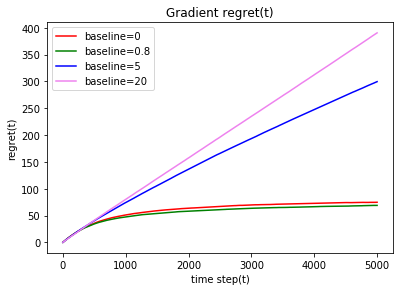

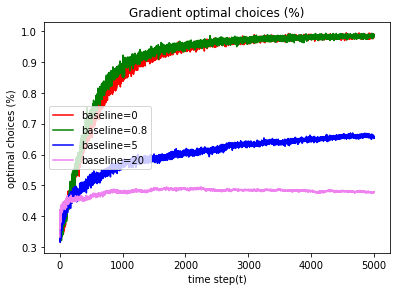

In [2]:
simulate(gradient, 5000, 1000, [[0, 1], [0.8, 1], [5, 1], [20, 1]], "Gradient", "baseline")

Overall regret = 234.4439999999997
Average aggragate reward: 4265.556
Average theta: th_1 = 0.686961, th_2 = 0.1565488, th_3 = 0.1564902
Overall regret = 71.64999999999947
Average aggragate reward: 4428.35
Average theta: th_1 = 0.9062324000000008, th_2 = 0.046926800000000025, th_3 = 0.04684080000000003
Overall regret = 39.899999999999466
Average aggragate reward: 4460.1
Average theta: th_1 = 0.9465722000000002, th_2 = 0.026655799999999962, th_3 = 0.02677199999999998
Overall regret = 18.947000000001598
Average aggragate reward: 4481.053
Average theta: th_1 = 0.9742764000000007, th_2 = 0.01285619999999999, th_3 = 0.012867399999999996


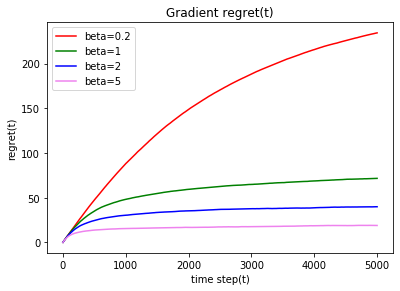

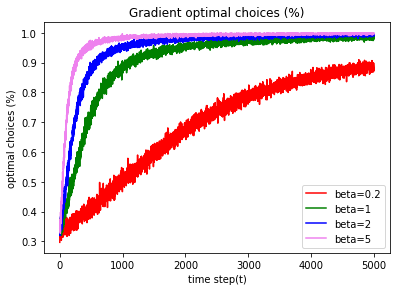

In [5]:
simulate(gradient, 5000, 1000, [[-1, 0.2], [-1, 1], [-1, 2], [-1, 5]], "Gradient", "beta")

Overall regret = 9.898000000000826
Average aggragate reward: 4490.102
Average theta: th_1 = 0.9868201999999996, th_2 = 0.006552799999999987, th_3 = 0.006626999999999991


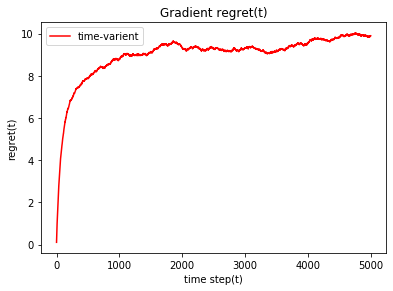

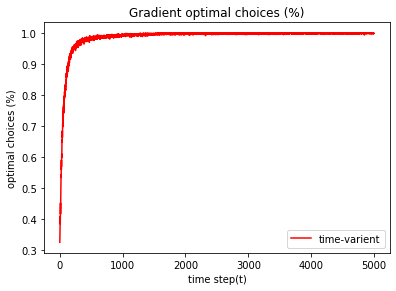

In [38]:
simulate(gradient, 5000, 1000, [[-1, 2]], "Gradient", "time-varient")

## Explanation about $Avg. \theta$ in gradient algorithm
## It's **not** really the $\hat{\theta}$, just the percentage of each arm was selected